### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime



### Import the csv file

In [2]:
Info = pd.read_csv('C:\DataScience_Interview\Expedia_Flight_Delay_Prediction\Microsoft Stock\Microsoft_Stock.csv')
Info["Date"] = pd.to_datetime(Info["Date"])
Info = Info.set_index("Date")
Info.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [3]:
Info.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


### We are going to look at how stationary is the data  
Investigating the following characteristics:
mean, variance, and Autocovariance


### 1- Dickey-Fuller Test for Moving Average  
For stock data at close

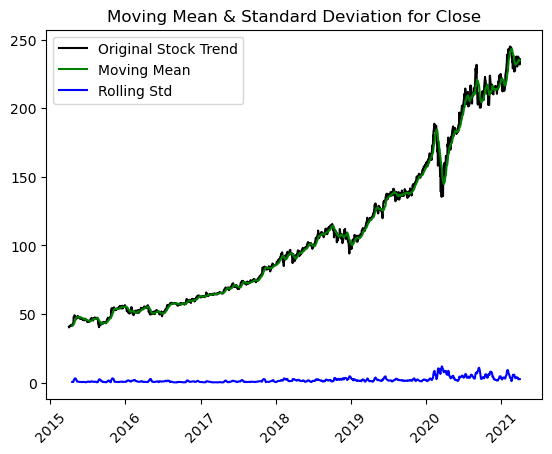

Results of the Dickey-Fuller Test:
Null hypothesis rejected: data is non-stationary.
p-value                       1.737136
Number of observation Used    0.998216
Critical Value (1%)          -3.434758
Critical Value (5%)          -2.863487
Critical Value (10%)         -2.567807
dtype: float64


In [4]:
from statsmodels.tsa.stattools import adfuller

rolmean = Info['Close'].rolling(window = 12, center = False).mean()
rolstd = Info['Close'].rolling(window = 12, center = False).std()

# Plot rolling statistics:
orig = plt.plot(Info['Close'],
               color = 'black',
               label = 'Original Stock Trend')
mean = plt.plot(rolmean,
               color = 'green',
               label = 'Moving Mean')
std = plt.plot(rolstd,
              color = 'blue',
              label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Moving Mean & Standard Deviation for Close')
plt.xticks(rotation = 45)
plt.show()


print('Results of the Dickey-Fuller Test:')

dftest = adfuller(Info['Close'],
                 autolag = 'AIC')
dfoutput = pd.Series(dftest[0:2],
                    index = ['p-value',
                            'Number of observation Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value

if (dftest[1] <= 0.05):
    print('Null hypothesis not rejected: data is stationary')
else:
    print('Null hypothesis rejected: data is non-stationary.')

print(dfoutput)
    
    


It can be seen that the "Moving Mean" and "Moving Std" changed over time. The changes are more prominent in "Moving Mean".  
With the p-value being higher than 0.05 from the Dickey-Fuller Test, we can conclude that the timeseries is non-stationary.

In order to handle non-stationary data to ultimately avoid mis-specifying variance and better fit the predicting model to data, the following methods can be used:  
Transformation (e.g., log, square root)  
Smoothing (e.g., Weekly average, monthly average, rolling averages)  
Diffrencing(e.g. First-order differencing)  
Ploynomial Fitting (e.g., Fit a regression model)  
Decomposition

### 2- Timeseries Decomposition  
  
Here we use decomposition method as below.

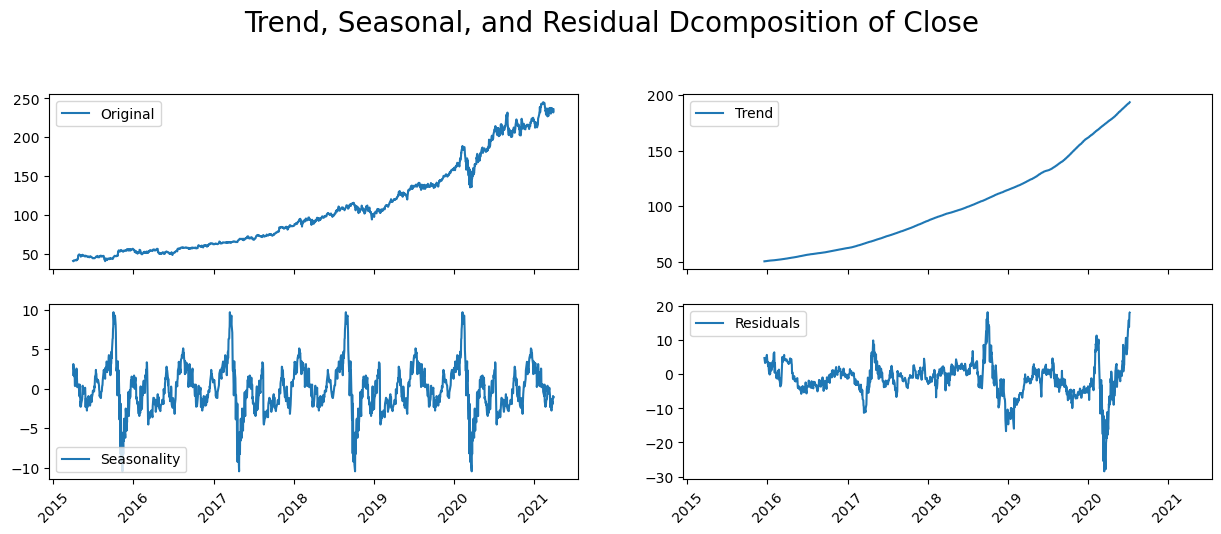

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(Info['Close'], period = 365)

Info.loc[:, 'trend'] = decomposition.trend
Info.loc[:, 'seasonal'] = decomposition.seasonal
Info.loc[:, 'residual'] = decomposition.resid

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)
    
ax1.plot(Info['Close'], label = 'Original')
ax1.legend(loc = 'best')
ax1.tick_params(axis = 'x', rotation = 45)

ax2.plot(Info['trend'], label = 'Trend') # Trend- is mean constant over time? (The increasing or decreasing value in the series.)
ax2.legend(loc = 'best')
ax2.tick_params(axis = 'x', rotation = 45)

ax3.plot(Info['seasonal'], label = 'Seasonality') # Seasonality- is variance constant over time? (The repeating short-term cycle in the series.)
ax3.legend(loc = 'best')
ax3.tick_params(axis = 'x', rotation = 45)

ax4.plot(Info['residual'], label = 'Residuals')
ax4.legend(loc = 'best')
ax4.tick_params(axis = 'x', rotation = 45)

# Show Graph
plt.suptitle('Trend, Seasonal, and Residual Dcomposition of Close',
            x = 0.5,
            y = 1.05,
            fontsize = 20)
plt.show()
plt.close()

#test_stationarity(df.dropna(), ts = 'residual')

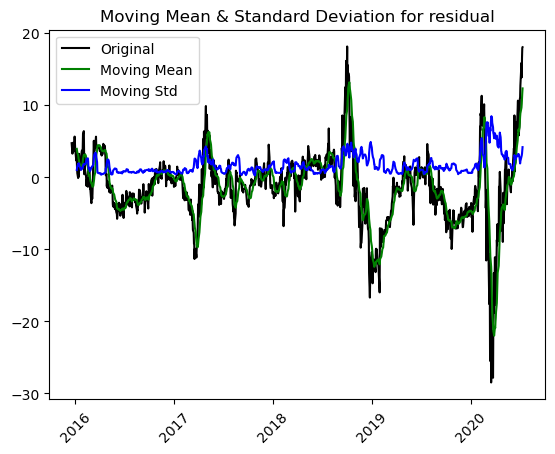

Results of the Dickey-Fuller Test:
Null hypothesis not rejected: data is stationary
p-value                      -4.107010
Number of observation Used    0.000943
Critical Value (1%)          -3.436186
Critical Value (5%)          -2.864117
Critical Value (10%)         -2.568142
dtype: float64


In [6]:
from statsmodels.tsa.stattools import adfuller

Info = Info.dropna()

rolmean = Info['residual'].rolling(window = 12, center = False).mean()
rolstd = Info['residual'].rolling(window = 12, center = False).std()

# Plot rolling statistics:
orig = plt.plot(Info['residual'],
               color = 'black',
               label = 'Original')
mean = plt.plot(rolmean,
               color = 'green',
               label = 'Moving Mean')
std = plt.plot(rolstd,
              color = 'blue',
              label = 'Moving Std')
plt.legend(loc = 'best')
plt.title('Moving Mean & Standard Deviation for residual')
plt.xticks(rotation = 45)
plt.show(block = False)
plt.close()

print('Results of the Dickey-Fuller Test:')

dftest = adfuller(Info['residual'],
                 autolag = 'AIC')
dfoutput = pd.Series(dftest[0:2],
                    index = ['p-value',
                            'Number of observation Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value

if (dftest[1] <= 0.05):
    print('Null hypothesis not rejected: data is stationary')
else:
    print('Null hypothesis rejected: data is non-stationary.')
    
print(dfoutput)
    

One now observes that the signal is converted to stationary and is ready to be further analyzed.

### 3-  Auto-Rgression Moving Average (ARIMA) Analysis  

It assumes that the signal is stationary and depends on Number of AR (Auto-Regressive) terms (p), Number of I (Integrated or Difference) terms (d), and Number of MA (Moving Average) terms (q).

##### Plotting Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

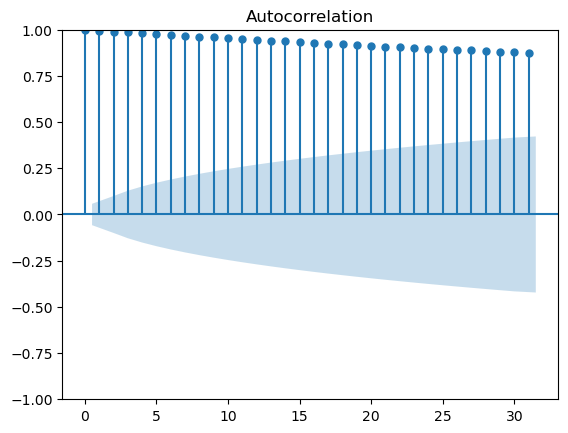

In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(Info['Close']);

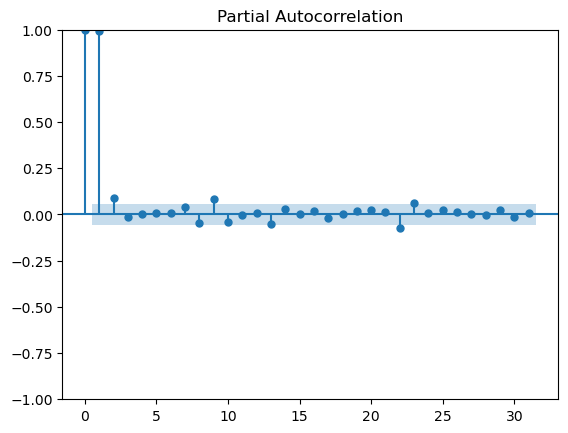

In [8]:
plot_pacf(Info['Close'], method='ywm');

One can observe that:  

The ACF lag 1 is above the blue region and p=1.  

The timeseries is stationary (p<0.05) with one order of differencing and d=1.  

Lags 1 and 2 cross the hazed blue region and q=1. 